# Analyzing Spotify Data w/ Visuals and Categorizing Songs with Machine Learning

The purpose of this project was to get familiar with the Spotify API and to practice with general data science techniques using the pandas, maplotlib, numpy, and sci-kit learn libraries. In order, this notebook does the following: 
* Plots my top artists (short-term, medium-term, and long-term) vs. their popularity levels 
* Plots my top tracks (short-term, medium-term, and long-term) vs. their durations
* Builds and evaluates machine learning models that categorize whether or not a song belongs to a more high energy workout playlist or to a more chill and relaxed playlist

In [311]:
import os
from dotenv import load_dotenv
load_dotenv()
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Retrieve variables from .env file and use them to access the Spotify API

In [312]:
client_id = os.getenv('SPOTIPY_CLIENT_ID')
client_secret = os.getenv('SPOTIPY_CLIENT_SECRET')
redirect_uri = os.getenv('SPOTIPY_REDIRECT_URI')

In [313]:
#the specified scopes allow us to access certain data
oauth_object = spotipy.SpotifyOAuth(client_id, client_secret, redirect_uri, scope='user-read-private user-read-email user-follow-read user-top-read') 
token_dict = oauth_object.get_cached_token()
token = token_dict['access_token'] 
spotify_obj = spotipy.Spotify(auth=token) 
curr_user = spotify_obj.current_user() 

### Get my top artists data for all three timeframes and format this data into a Pandas DataFrames

In [314]:
def get_top_artists(term_length, redacted_artist_index):
    top_dict = spotify_obj.current_user_top_artists(limit=10, offset=0, time_range=term_length)
    artist_info = top_dict['items']
    artist_df = pd.DataFrame(artist_info)
    artist_df = artist_df.drop(index=redacted_artist_index)
    artist_df = artist_df.reset_index(drop=True)
    return artist_df

In [315]:
#short-term top artists
artist_df_st = get_top_artists('short_term', 4)
artist_df_st.head()

external_urls  \
0  {'spotify': 'https://open.spotify.com/artist/4...   
1  {'spotify': 'https://open.spotify.com/artist/3...   
2  {'spotify': 'https://open.spotify.com/artist/4...   
3  {'spotify': 'https://open.spotify.com/artist/6...   
4  {'spotify': 'https://open.spotify.com/artist/5...   

                    followers  \
0  {'href': None, 'total': 0}   
1  {'href': None, 'total': 0}   
2  {'href': None, 'total': 0}   
3  {'href': None, 'total': 0}   
4  {'href': None, 'total': 0}   

                                              genres  \
0                        [melodic rap, pluggnb, rap]   
1  [canadian hip hop, canadian pop, hip hop, pop ...   
2                               [pop rap, rap, trap]   
3  [classic soul, funk, motown, philly soul, quie...   
4           [barbadian pop, pop, urban contemporary]   

                                                href                      id  \
0  https://api.spotify.com/v1/artists/4Ga1P7PMIsm...  4Ga1P7PMIsmqEZqhYZQgDo   
1  https://api.spotify.com/v1/artists/3TVXtAsR1In...  3TVXtAsR1Inumwj472S9r4   
2  https://api.spotify.com/v1/artists/4Gso3d4CscC...  4Gso3d4CscCijv0lmajZWs   
3  https://api.spotify.com/v1/artists/68kACMx6A3D...  68kACMx6A3D2BYiO056MeQ   
4  https://api.spotify.com/v1/artists/5pKCCKE2ajJ...  5pKCCKE2ajJHZ9KAiaK11H   

                                              images               name  \
0  [{'height': 640, 'url': 'https://i.scdn.co/ima...          Lil Tecca   
1  [{'height': 640, 'url': 'https://i.scdn.co/ima...              Drake   
2  [{'height': 640, 'url': 'https://i.scdn.co/ima...        Don Toliver   
3  [{'height': 640, 'url': 'https://i.scdn.co/ima...  Teddy Pendergrass   
4  [{'height': 640, 'url': 'https://i.scdn.co/ima...            Rihanna   

   popularity    type                                    uri  
0          79  artist  spotify:artist:4Ga1P7PMIsmqEZqhYZQgDo  
1          96  artist  spotify:artist:3TVXtAsR1Inumwj472S9r4  
2          79  artist  spotify:artist:4Gso3d4CscCijv0lmajZWs  
3          55  artist  spotify:artist:68kACMx6A3D2BYiO056MeQ  
4          87  artist  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H

In [316]:
#medium-term top artists
artist_df_mt = get_top_artists('medium_term', 1)
artist_df_mt.head()

external_urls  \
0  {'spotify': 'https://open.spotify.com/artist/3...   
1  {'spotify': 'https://open.spotify.com/artist/4...   
2  {'spotify': 'https://open.spotify.com/artist/4...   
3  {'spotify': 'https://open.spotify.com/artist/3...   
4  {'spotify': 'https://open.spotify.com/artist/2...   

                    followers  \
0  {'href': None, 'total': 0}   
1  {'href': None, 'total': 0}   
2  {'href': None, 'total': 0}   
3  {'href': None, 'total': 0}   
4  {'href': None, 'total': 0}   

                                              genres  \
0  [canadian hip hop, canadian pop, hip hop, pop ...   
1                               [pop rap, rap, trap]   
2            [hip hop, pittsburgh rap, pop rap, rap]   
3  [east coast hip hop, gangster rap, hip hop, po...   
4              [atl hip hop, melodic rap, rap, trap]   

                                                href                      id  \
0  https://api.spotify.com/v1/artists/3TVXtAsR1In...  3TVXtAsR1Inumwj472S9r4   
1  https://api.spotify.com/v1/artists/4Gso3d4CscC...  4Gso3d4CscCijv0lmajZWs   
2  https://api.spotify.com/v1/artists/4LLpKhyESsy...  4LLpKhyESsyAXpc4laK94U   
3  https://api.spotify.com/v1/artists/3nFkdlSjzX9...  3nFkdlSjzX9mRTtwJOzDYB   
4  https://api.spotify.com/v1/artists/2hlmm7s2ICU...  2hlmm7s2ICUX0LVIhVFlZQ   

                                              images         name  popularity  \
0  [{'height': 640, 'url': 'https://i.scdn.co/ima...        Drake          96   
1  [{'height': 640, 'url': 'https://i.scdn.co/ima...  Don Toliver          79   
2  [{'height': 640, 'url': 'https://i.scdn.co/ima...   Mac Miller          80   
3  [{'height': 640, 'url': 'https://i.scdn.co/ima...        JAY-Z          81   
4  [{'height': 640, 'url': 'https://i.scdn.co/ima...        Gunna          83   

     type                                    uri  
0  artist  spotify:artist:3TVXtAsR1Inumwj472S9r4  
1  artist  spotify:artist:4Gso3d4CscCijv0lmajZWs  
2  artist  spotify:artist:4LLpKhyESsyAXpc4laK94U  
3  artist  spotify:artist:3nFkdlSjzX9mRTtwJOzDYB  
4  artist  spotify:artist:2hlmm7s2ICUX0LVIhVFlZQ

In [317]:
#long-term top artists
artist_df_lt = get_top_artists('long_term', 0)
artist_df_lt.head()

external_urls  \
0  {'spotify': 'https://open.spotify.com/artist/3...   
1  {'spotify': 'https://open.spotify.com/artist/4...   
2  {'spotify': 'https://open.spotify.com/artist/1...   
3  {'spotify': 'https://open.spotify.com/artist/6...   
4  {'spotify': 'https://open.spotify.com/artist/2...   

                    followers  \
0  {'href': None, 'total': 0}   
1  {'href': None, 'total': 0}   
2  {'href': None, 'total': 0}   
3  {'href': None, 'total': 0}   
4  {'href': None, 'total': 0}   

                                              genres  \
0  [canadian hip hop, canadian pop, hip hop, pop ...   
1            [hip hop, pittsburgh rap, pop rap, rap]   
2          [adult standards, easy listening, lounge]   
3                           [melodic rap, rap, trap]   
4                                      [jersey club]   

                                                href                      id  \
0  https://api.spotify.com/v1/artists/3TVXtAsR1In...  3TVXtAsR1Inumwj472S9r4   
1  https://api.spotify.com/v1/artists/4LLpKhyESsy...  4LLpKhyESsyAXpc4laK94U   
2  https://api.spotify.com/v1/artists/1Mxqyy3pSjf...  1Mxqyy3pSjf8kZZL4QVxS0   
3  https://api.spotify.com/v1/artists/6Xgp2XMz1fh...  6Xgp2XMz1fhVYe7i6yNAax   
4  https://api.spotify.com/v1/artists/2R0CFyeMDiR...  2R0CFyeMDiRbfkhkIMbyl1   

                                              images           name  \
0  [{'height': 640, 'url': 'https://i.scdn.co/ima...          Drake   
1  [{'height': 640, 'url': 'https://i.scdn.co/ima...     Mac Miller   
2  [{'height': 650, 'url': 'https://i.scdn.co/ima...  Frank Sinatra   
3  [{'height': 640, 'url': 'https://i.scdn.co/ima...   Trippie Redd   
4  [{'height': 640, 'url': 'https://i.scdn.co/ima...    Cash Cobain   

   popularity    type                                    uri  
0          96  artist  spotify:artist:3TVXtAsR1Inumwj472S9r4  
1          80  artist  spotify:artist:4LLpKhyESsyAXpc4laK94U  
2          74  artist  spotify:artist:1Mxqyy3pSjf8kZZL4QVxS0  
3          78  artist  spotify:artist:6Xgp2XMz1fhVYe7i6yNAax  
4          44  artist  spotify:artist:2R0CFyeMDiRbfkhkIMbyl1

## Plot my top artists data for all three timeframes -- compare popularity of artists

In [318]:
def plot_top_artists(df, term_length):
    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(12,6), dpi = 90)
    
    # Plot initial bars
    bar1 = ax.bar(df['name'], df['popularity'], width=0.6)
    # Label the axes
    ax.set_xlabel('Artist Names', fontsize=20, labelpad=8)
    ax.set_ylabel('Popularity', fontsize=20, labelpad=8)
    ax.xaxis.label.set_color('#023020')
    ax.yaxis.label.set_color('#023020')
    ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=80)
    
    # Add label on top of each bar to show precise popularity measurement
    ax.bar_label(bar1, labels=df['popularity'], padding=3, color='#000000', fontsize=8);
    ax.tick_params(colors='#023020', which='both')
    # Add in stylistic line on top
    ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#023020', linewidth=.6)
    
    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s=f'Popularity Levels of My Top Artists ({term_length})', transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    ax.text(x=0.12, y=.90, s='Popularity is ranked from 0 (Least Popular) to 100 (Most Popular)', transform=fig.transFigure, ha='left', fontsize=12, alpha=.8);
    
    # Colours - Choose the extreme colours of the colour map
    colours = ['#A4BF5B', '#063B00']
    # Colormap - Build the colour maps
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colour_map', colours, N=256)
    norm = matplotlib.colors.Normalize(df['popularity'].min(), df['popularity'].max()) # linearly normalizes data into the [0.0, 1.0] interval
    # Plot stylized bars
    bar1 = ax.bar(df['name'], df['popularity'], color=cmap(norm(df['popularity'])), width=0.6)
    
    #Calculate, plot, and annotate the average line
    average = np.mean(df['popularity'])
    plt.axhline(y=average, color = '#ff0000', linewidth=3)
    ax.text(0.88, 0.82, f'Average = {average:.1f}', ha='right', va='center', color='#ff0000', style='oblique', transform=ax.transAxes, size=12, zorder=3)


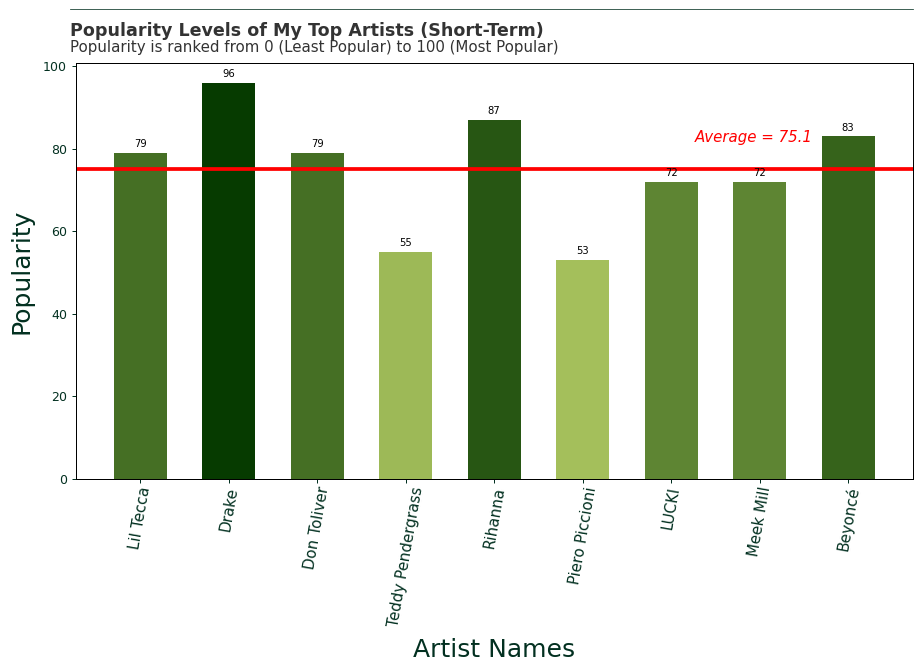

In [319]:
plot_top_artists(artist_df_st, 'Short-Term')

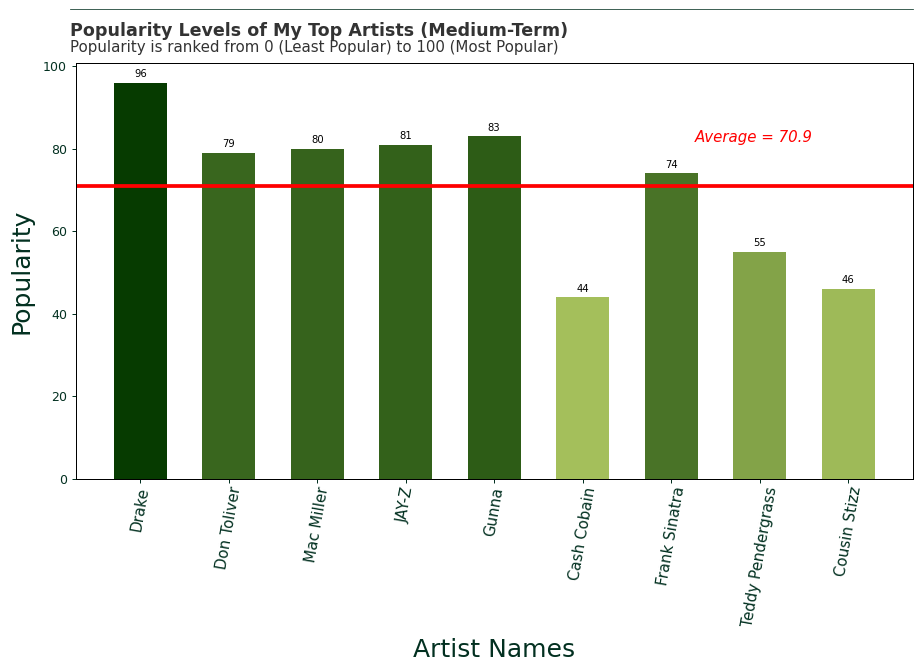

In [320]:
plot_top_artists(artist_df_mt, 'Medium-Term')

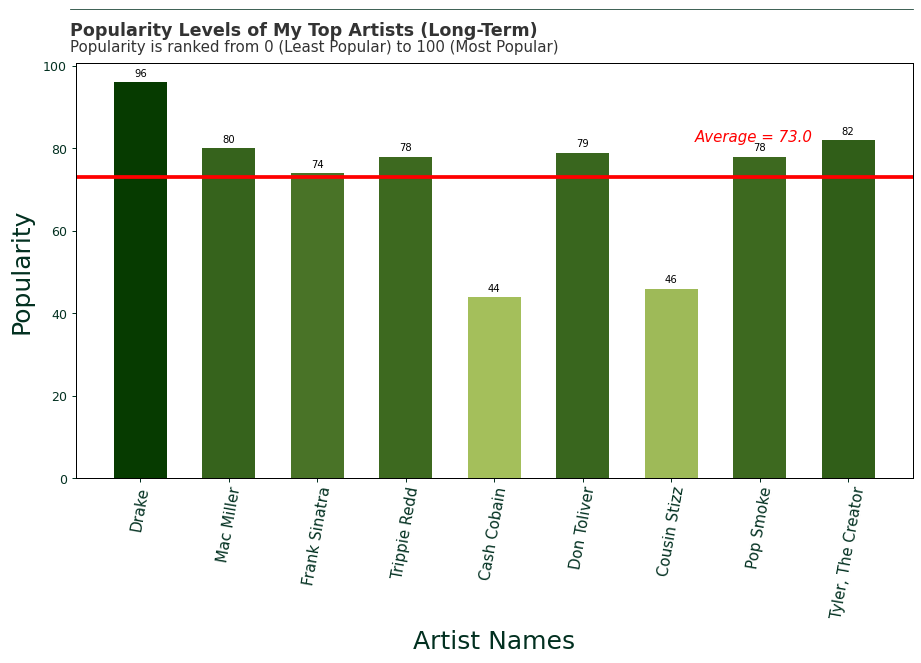

In [321]:
plot_top_artists(artist_df_lt, 'Long-Term')

### In all three timeframes, it seems that the average poplarity of my top artists lie around the 70's so it's fair to say that I listen to mostly well-known artists. It's also interesting to note that for the short-term timeframe, the two least popular artists are also the only two artists who happen to not be in the pop/rap category of music.

## Get my top track data for all three timeframes and format this data into Pandas DataFrames

In [322]:
def get_top_tracks(term_length):
    top_dict = spotify_obj.current_user_top_tracks(limit=10, offset=0, time_range=term_length)
    track_info = top_dict['items']
    track_df = pd.DataFrame(track_info)
    #converting duration from millescond to more readable minute and second format
    track_df['length'] = pd.to_datetime(track_df['duration_ms'], unit = 'ms')
    #Calculating average before stringifying
    avg = np.mean(track_df['length'])
    track_df['length'] = track_df['length'].apply(lambda x: x.strftime('%M:%S'))
    #Getting average duration in stringified format
    avg_duration = avg.strftime('%M:%S')
    #converting to float so that data can be plotted on the y axis based on value
    track_df['length'] = track_df['length'].apply(lambda x: x.replace(':','.'))
    track_df['length'] = track_df['length'].apply(lambda x: float(x))
    return track_df, avg_duration

In [323]:
track_df_st, st_avg = get_top_tracks('short_term')
track_df_st.head()

album  \
0  {'album_type': 'ALBUM', 'artists': [{'external...   
1  {'album_type': 'ALBUM', 'artists': [{'external...   
2  {'album_type': 'ALBUM', 'artists': [{'external...   
3  {'album_type': 'ALBUM', 'artists': [{'external...   
4  {'album_type': 'ALBUM', 'artists': [{'external...   

                                             artists  \
0  [{'external_urls': {'spotify': 'https://open.s...   
1  [{'external_urls': {'spotify': 'https://open.s...   
2  [{'external_urls': {'spotify': 'https://open.s...   
3  [{'external_urls': {'spotify': 'https://open.s...   
4  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  disc_number  \
0  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
1  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
2  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
3  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
4  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   

   duration_ms  explicit              external_ids  \
0       251094      True  {'isrc': 'USUG12306066'}   
1       312866      True  {'isrc': 'USQX92203089'}   
2       354626     False  {'isrc': 'USPH37900001'}   
3       220240      True  {'isrc': 'USSM11809245'}   
4       131858      True  {'isrc': 'USUM72312823'}   

                                       external_urls  \
0  {'spotify': 'https://open.spotify.com/track/3e...   
1  {'spotify': 'https://open.spotify.com/track/1I...   
2  {'spotify': 'https://open.spotify.com/track/47...   
3  {'spotify': 'https://open.spotify.com/track/0W...   
4  {'spotify': 'https://open.spotify.com/track/14...   

                                                href                      id  \
0  https://api.spotify.com/v1/tracks/3eP13S8D5m2c...  3eP13S8D5m2cweMEg3ZDed   
1  https://api.spotify.com/v1/tracks/1IfELgl6y4O9...  1IfELgl6y4O99Tp3jTGYOv   
2  https://api.spotify.com/v1/tracks/47nJdvSobIGB...  47nJdvSobIGBYdN7y2caLM   
3  https://api.spotify.com/v1/tracks/0W64NfLrIsRT...  0W64NfLrIsRTAFObko6uJx   
4  https://api.spotify.com/v1/tracks/14QI6pBFZ9Ut...  14QI6pBFZ9UtMqze2QdJhm   

   is_local                  name  popularity  \
0     False        Virginia Beach          88   
1     False  Written in the Stars          46   
2     False   Turn off the Lights          52   
3     False                Leaked          71   
4     False                   TEC          71   

                                         preview_url  track_number   type  \
0  https://p.scdn.co/mp3-preview/53fd1aafb5d4fbca...             1  track   
1  https://p.scdn.co/mp3-preview/45686accce2d11ca...            14  track   
2  https://p.scdn.co/mp3-preview/b014dd6b9183eb85...             2  track   
3  https://p.scdn.co/mp3-preview/09dd1289ada149cc...            10  track   
4  https://p.scdn.co/mp3-preview/8924a54c3f1461bf...             6  track   

                                    uri  length  
0  spotify:track:3eP13S8D5m2cweMEg3ZDed    4.11  
1  spotify:track:1IfELgl6y4O99Tp3jTGYOv    5.12  
2  spotify:track:47nJdvSobIGBYdN7y2caLM    5.54  
3  spotify:track:0W64NfLrIsRTAFObko6uJx    3.40  
4  spotify:track:14QI6pBFZ9UtMqze2QdJhm    2.11

In [324]:
track_df_mt, mt_avg = get_top_tracks('medium_term')
track_df_mt.head()

album  \
0  {'album_type': 'ALBUM', 'artists': [{'external...   
1  {'album_type': 'ALBUM', 'artists': [{'external...   
2  {'album_type': 'ALBUM', 'artists': [{'external...   
3  {'album_type': 'ALBUM', 'artists': [{'external...   
4  {'album_type': 'ALBUM', 'artists': [{'external...   

                                             artists  \
0  [{'external_urls': {'spotify': 'https://open.s...   
1  [{'external_urls': {'spotify': 'https://open.s...   
2  [{'external_urls': {'spotify': 'https://open.s...   
3  [{'external_urls': {'spotify': 'https://open.s...   
4  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  disc_number  \
0  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
1  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
2  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
3  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
4  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            2   

   duration_ms  explicit              external_ids  \
0       312866      True  {'isrc': 'USQX92203089'}   
1       234693     False  {'isrc': 'USUM72308572'}   
2       195720      True  {'isrc': 'USCM51800202'}   
3       279451     False  {'isrc': 'GBKPL2144831'}   
4       290000     False  {'isrc': 'USMC10001010'}   

                                       external_urls  \
0  {'spotify': 'https://open.spotify.com/track/1I...   
1  {'spotify': 'https://open.spotify.com/track/0K...   
2  {'spotify': 'https://open.spotify.com/track/0z...   
3  {'spotify': 'https://open.spotify.com/track/4H...   
4  {'spotify': 'https://open.spotify.com/track/0c...   

                                                href                      id  \
0  https://api.spotify.com/v1/tracks/1IfELgl6y4O9...  1IfELgl6y4O99Tp3jTGYOv   
1  https://api.spotify.com/v1/tracks/0KoBrntyQ2x6...  0KoBrntyQ2x6Y1eZwgGe5P   
2  https://api.spotify.com/v1/tracks/0zqy3ss4CwD6...  0zqy3ss4CwD6u4QPksS0nI   
3  https://api.spotify.com/v1/tracks/4HvvHSzR1fAS...  4HvvHSzR1fAS653pHO5XTu   
4  https://api.spotify.com/v1/tracks/0cAiOfc6uxr6...  0cAiOfc6uxr6NCyQ80ZigK   

   is_local                                               name  popularity  \
0     False                               Written in the Stars          46   
1     False  Givin’ Up (Not The One) (Don Toliver & 21 Sava...          71   
2     False                                        8 Out Of 10          63   
3     False                                Under the Same Name          51   
4     False     On Our Own - From "Ghostbusters II" Soundtrack          47   

                                         preview_url  track_number   type  \
0  https://p.scdn.co/mp3-preview/45686accce2d11ca...            14  track   
1  https://p.scdn.co/mp3-preview/d28ed256d49b1446...            12  track   
2  https://p.scdn.co/mp3-preview/cb1c149a15e507c4...             7  track   
3  https://p.scdn.co/mp3-preview/439368e466bee55e...            10  track   
4  https://p.scdn.co/mp3-preview/5f2695a366ca3796...             1  track   

                                    uri  length  
0  spotify:track:1IfELgl6y4O99Tp3jTGYOv    5.12  
1  spotify:track:0KoBrntyQ2x6Y1eZwgGe5P    3.54  
2  spotify:track:0zqy3ss4CwD6u4QPksS0nI    3.15  
3  spotify:track:4HvvHSzR1fAS653pHO5XTu    4.39  
4  spotify:track:0cAiOfc6uxr6NCyQ80ZigK    4.50

In [325]:
track_df_lt, lt_avg = get_top_tracks('long_term')
track_df_lt.head()

album  \
0  {'album_type': 'ALBUM', 'artists': [{'external...   
1  {'album_type': 'ALBUM', 'artists': [{'external...   
2  {'album_type': 'ALBUM', 'artists': [{'external...   
3  {'album_type': 'ALBUM', 'artists': [{'external...   
4  {'album_type': 'SINGLE', 'artists': [{'externa...   

                                             artists  \
0  [{'external_urls': {'spotify': 'https://open.s...   
1  [{'external_urls': {'spotify': 'https://open.s...   
2  [{'external_urls': {'spotify': 'https://open.s...   
3  [{'external_urls': {'spotify': 'https://open.s...   
4  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  disc_number  \
0  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
1  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
2  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
3  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
4                                                 []            1   

   duration_ms  explicit              external_ids  \
0       312866      True  {'isrc': 'USQX92203089'}   
1       133762      True  {'isrc': 'USUG12104407'}   
2       326533     False  {'isrc': 'USSM11804486'}   
3       329426      True  {'isrc': 'USAT21402742'}   
4       214588     False  {'isrc': 'QZK6J2131668'}   

                                       external_urls  \
0  {'spotify': 'https://open.spotify.com/track/1I...   
1  {'spotify': 'https://open.spotify.com/track/1P...   
2  {'spotify': 'https://open.spotify.com/track/7b...   
3  {'spotify': 'https://open.spotify.com/track/0x...   
4  {'spotify': 'https://open.spotify.com/track/3x...   

                                                href                      id  \
0  https://api.spotify.com/v1/tracks/1IfELgl6y4O9...  1IfELgl6y4O99Tp3jTGYOv   
1  https://api.spotify.com/v1/tracks/1PDP7mLiAMwh...  1PDP7mLiAMwhfmgIwzhOm2   
2  https://api.spotify.com/v1/tracks/7bKxc7UstlRx...  7bKxc7UstlRxOtNBvLjGSs   
3  https://api.spotify.com/v1/tracks/0xdYzkbBBfTe...  0xdYzkbBBfTevSyOJqWUSX   
4  https://api.spotify.com/v1/tracks/3xO7yLHU8cTg...  3xO7yLHU8cTglvxXHFdrSc   

   is_local                                         name  popularity  \
0     False                         Written in the Stars          46   
1     False                           Yebba’s Heartbreak          82   
2     False                   It Gets Better (With Time)          54   
3     False  Sky's the Limit (feat. 112) - 2014 Remaster          64   
4     False                               retire (final)           1   

                                         preview_url  track_number   type  \
0  https://p.scdn.co/mp3-preview/45686accce2d11ca...            14  track   
1  https://p.scdn.co/mp3-preview/38439c23dba48a33...            11  track   
2  https://p.scdn.co/mp3-preview/b5b25242e2bb5ad8...             9  track   
3  https://p.scdn.co/mp3-preview/5eabbcaee521d7f6...            20  track   
4                                               None             4  track   

                                    uri  length  
0  spotify:track:1IfELgl6y4O99Tp3jTGYOv    5.12  
1  spotify:track:1PDP7mLiAMwhfmgIwzhOm2    2.13  
2  spotify:track:7bKxc7UstlRxOtNBvLjGSs    5.26  
3  spotify:track:0xdYzkbBBfTevSyOJqWUSX    5.29  
4  spotify:track:3xO7yLHU8cTglvxXHFdrSc    3.34

## Plot my top track data for all three timeframes -- compare duration of tracks

In [326]:
def plot_top_tracks(df, term_length, avg):
    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(12,6), dpi = 90)
    
    # Plot initial bars
    bar1 = ax.bar(df['name'], df['length'], width=0.6)
    
    # Label the axes
    ax.set_xlabel('Song Names', fontsize=20, labelpad=8)
    ax.set_ylabel('Song Duration in Minutes', fontsize=20, labelpad=8)
    ax.xaxis.label.set_color('#FD6A02')
    ax.yaxis.label.set_color('#FD6A02')
    ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=80)
    
    # Add label on top of each bar to show precise duration length
    ax.bar_label(bar1, labels=df['length'], padding=3, color='#000000', fontsize=8);
    ax.tick_params(colors='#FD6A02', which='both')
    # Add in stylistic line on top
    ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#FD6A02', linewidth=.6)
    
    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s=f'Durations of My Top Songs ({term_length})', transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    ax.text(x=0.12, y=.90, s='Duration is measured in minutes and seconds', transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)
    
    # Colours - Choose the extreme colours of the colour map
    colours = ['#FFD580', '#FF7518']
    # Colormap - Build the colour maps
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colour_map', colours, N=256)
    norm = matplotlib.colors.Normalize(df['length'].min(), df['length'].max()) # linearly normalizes data into the [0.0, 1.0] interval
    # Plot stylized bars
    bar1 = ax.bar(df['name'], df['length'], color=cmap(norm(df['length'])), width=0.6, )
    
    #Calculate, plot, and annotate the average line
    average = np.mean(track_df_st['length'])
    plt.axhline(y=average, color = '#ff0000', linewidth=3)
    ax.text(0.75, 0.77, f'Average = {avg}', ha='right', va='center', color='#ff0000', style='oblique', transform=ax.transAxes, size=12, zorder=3)

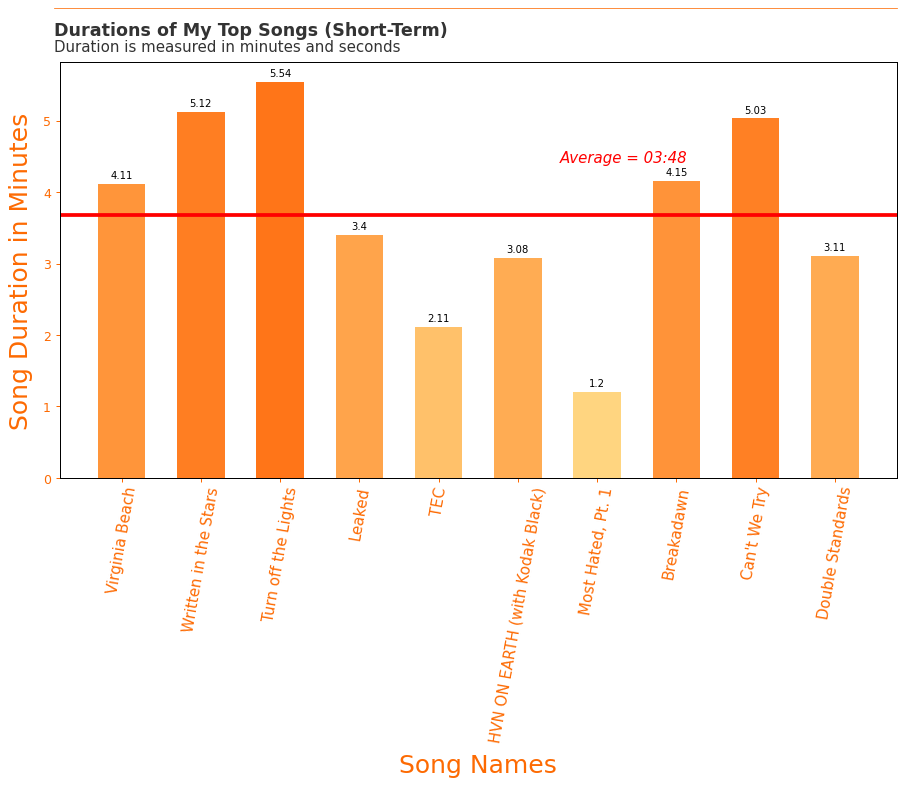

In [327]:
plot_top_tracks(track_df_st, 'Short-Term', st_avg)

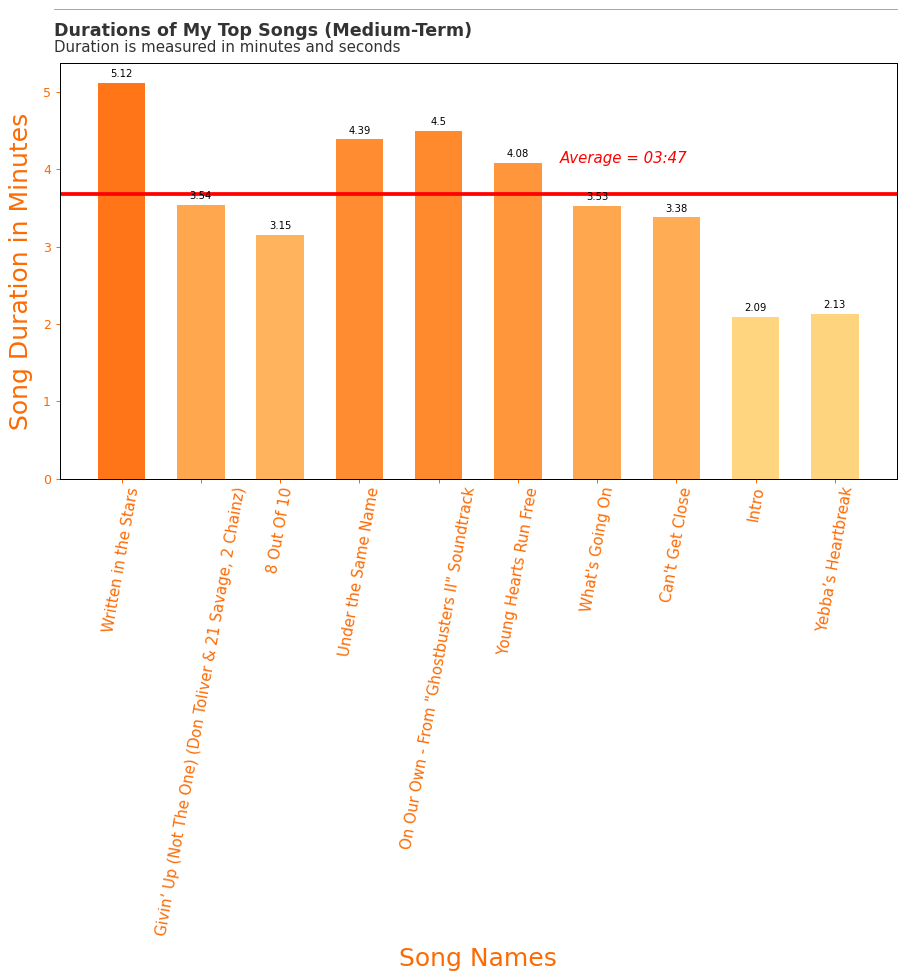

In [328]:
plot_top_tracks(track_df_mt, 'Medium-Term', mt_avg)

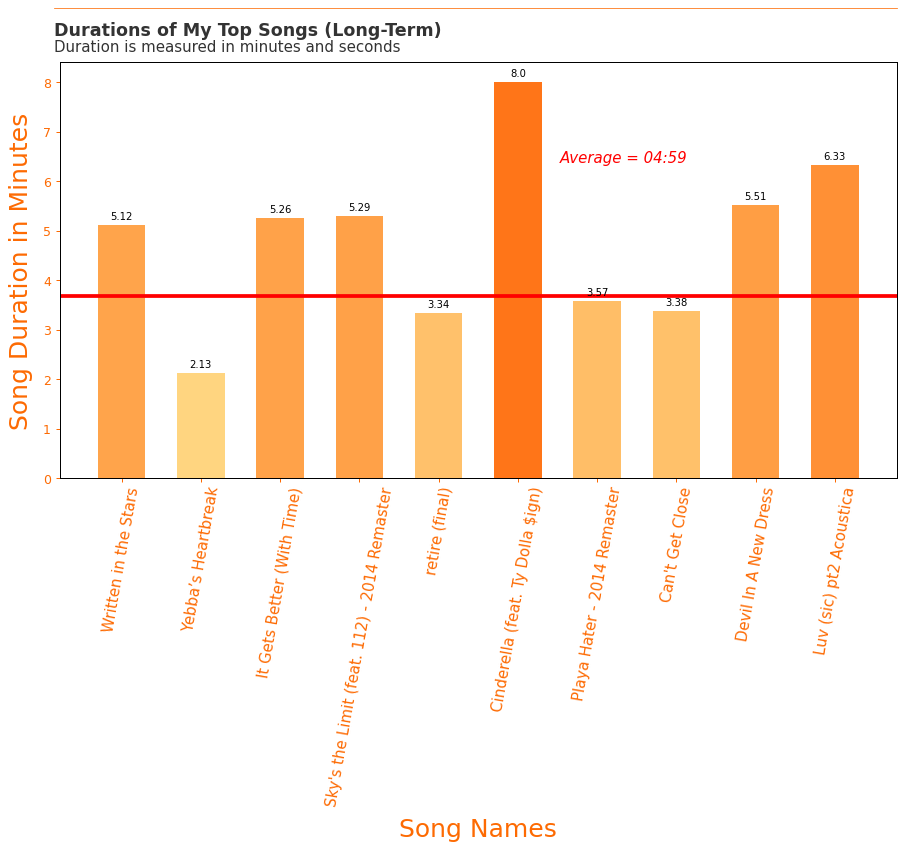

In [329]:
plot_top_tracks(track_df_lt, 'Long-Term', lt_avg)

### It's interesting to note how a lot of the songs that I enjoy tend to be on the longer side -- all of my #1 throughout each timeframe have a duration of more than 5 seconds. This is especially intriguing when you consider the following article, which cites how there seems to be a trend in which shorter songs (around 3 minutes) do much better in terms of popularity and streams. 
https://www.statista.com/chart/26546/mean-song-duration-of-currently-streamable-songs-by-year-of-release/#:~:text=Music%20through%20the%20decades&text=The%20average%20song%20released%20on,song%20lengths%20starting%20in%201990.

# Machine Learning Segment
## First, for each track from both playlists, the features must be retrieved and then correctly formatted into a pandas dataframe

In [330]:
def get_track_features(playlist_link, cat_label):
    #get playlist and only get track info
    playlist = spotify_obj.playlist(playlist_link)
    tracks = playlist['tracks']
    #get uris for each track
    uri_list = []
    track_list = tracks['items']
    for track in track_list:
        uri_list.append(track['track']['uri'])
    #get audio features for each track
    uri_audio_features = spotify_obj.audio_features(uri_list)
    #create initial dataframe with 1 row and transform data to fit this format
    audio_feats = uri_audio_features[0].items()
    audio_data = list(audio_feats)
    np_arr_audio = np.array(audio_data)
    features_df = pd.DataFrame(np_arr_audio.T)
    #loop through rest of the data and after transforming each track's data, append it to the dataframe as a new row
    for curr_dict in uri_audio_features[1:]:
        #ensure the value isn't null (Spotify has none objects randomly appear in track info)
        if curr_dict:
            audio_data = list(curr_dict.items())
            np_arr_audio = np.array(audio_data)
            new_row = np_arr_audio.T
            features_df.loc[len(features_df)] = new_row[1]
            features_df.columns = features_df.iloc[0]

    #make the first row the column names and reset index after doing so
    features_df = features_df[1:]
    features_df.reset_index(drop=True, inplace=True)
    
    #add a column to indicate what category the song belongs to (chill or workout)
    features_df.loc[:, 'category'] = cat_label
    return features_df

In [331]:
workout_df = get_track_features('https://open.spotify.com/playlist/37i9dQZF1EIgzSCNweQzPQ?si=f4c5b1e4b7b748b1', 0)
workout_df.head()

0 danceability energy key loudness mode speechiness acousticness  \
0         0.47   0.64   2   -7.779    1        0.32       0.0277   
1        0.569  0.882   3   -2.777    0        0.06       0.0316   
2        0.668  0.727   1   -4.613    1       0.248       0.0301   
3        0.619  0.606   1   -4.252    1      0.0784       0.0268   
4        0.785  0.903   2   -4.184    1        0.21        0.258   

0 instrumentalness liveness valence    tempo            type  \
0                0    0.382   0.248   163.92  audio_features   
1                0    0.142   0.201  148.038  audio_features   
2                0    0.143   0.309  143.083  audio_features   
3                0    0.375  0.0669  140.023  audio_features   
4                0    0.169   0.565   139.98  audio_features   

0                      id                                   uri  \
0  7aqfrAY2p9BUSiupwk3svU  spotify:track:7aqfrAY2p9BUSiupwk3svU   
1  42VsgItocQwOQC3XWZ8JNA  spotify:track:42VsgItocQwOQC3XWZ8JNA   
2  2N9LEu6Pf8nDcp3GjWJT1Z  spotify:track:2N9LEu6Pf8nDcp3GjWJT1Z   
3  1pDbGAAH5GQ8U0KG4fI77H  spotify:track:1pDbGAAH5GQ8U0KG4fI77H   
4  29TPjc8wxfz4XMn21O7VsZ  spotify:track:29TPjc8wxfz4XMn21O7VsZ   

0                                         track_href  \
0  https://api.spotify.com/v1/tracks/7aqfrAY2p9BU...   
1  https://api.spotify.com/v1/tracks/42VsgItocQwO...   
2  https://api.spotify.com/v1/tracks/2N9LEu6Pf8nD...   
3  https://api.spotify.com/v1/tracks/1pDbGAAH5GQ8...   
4  https://api.spotify.com/v1/tracks/29TPjc8wxfz4...   

0                                       analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/7aqf...      247444   
1  https://api.spotify.com/v1/audio-analysis/42Vs...      191701   
2  https://api.spotify.com/v1/audio-analysis/2N9L...       90720   
3  https://api.spotify.com/v1/audio-analysis/1pDb...       97770   
4  https://api.spotify.com/v1/audio-analysis/29TP...      193234   

0 time_signature  category  
0              4         0  
1              4         0  
2              4         0  
3              4         0  
4              4         0

In [332]:
chill_df = get_track_features('https://open.spotify.com/playlist/37i9dQZF1EIcNUtFW3CJZc?si=670a71cb3a8446b7', 1)
chill_df.head()

0 danceability energy key loudness mode speechiness acousticness  \
0        0.634  0.663  11   -6.818    1      0.0331        0.433   
1        0.873  0.252   2  -13.884    1      0.0425        0.766   
2        0.587  0.286   9   -8.839    1      0.0315        0.185   
3        0.471  0.634   8   -7.406    1       0.031        0.159   
4        0.742  0.546   1   -7.694    1      0.0315        0.172   

0 instrumentalness liveness valence    tempo            type  \
0            0.124    0.102     0.6  146.053  audio_features   
1          0.00661   0.0978   0.599  133.983  audio_features   
2           0.0288    0.214   0.302   71.123  audio_features   
3            0.365    0.374   0.366  132.542  audio_features   
4             0.38    0.115   0.868  104.996  audio_features   

0                      id                                   uri  \
0  41P6Tnd8KIHqON0QIydx6a  spotify:track:41P6Tnd8KIHqON0QIydx6a   
1  3oUn55qKRZ1JFzfQNbJjS1  spotify:track:3oUn55qKRZ1JFzfQNbJjS1   
2  2VYnlKxB8jpbCeLUjQsebc  spotify:track:2VYnlKxB8jpbCeLUjQsebc   
3  0TZejo18HlJ86OrWNsXKnw  spotify:track:0TZejo18HlJ86OrWNsXKnw   
4  6UFivO2zqqPFPoQYsEMuCc  spotify:track:6UFivO2zqqPFPoQYsEMuCc   

0                                         track_href  \
0  https://api.spotify.com/v1/tracks/41P6Tnd8KIHq...   
1  https://api.spotify.com/v1/tracks/3oUn55qKRZ1J...   
2  https://api.spotify.com/v1/tracks/2VYnlKxB8jpb...   
3  https://api.spotify.com/v1/tracks/0TZejo18HlJ8...   
4  https://api.spotify.com/v1/tracks/6UFivO2zqqPF...   

0                                       analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/41P6...      177533   
1  https://api.spotify.com/v1/audio-analysis/3oUn...      136888   
2  https://api.spotify.com/v1/audio-analysis/2VYn...      224680   
3  https://api.spotify.com/v1/audio-analysis/0TZe...      208500   
4  https://api.spotify.com/v1/audio-analysis/6UFi...      260520   

0 time_signature  category  
0              4         1  
1              4         1  
2              4         1  
3              4         1  
4              4         1

## Only use the columns that make sense in terms of features of a song, then combine the two dataframes

In [333]:
workout_data = workout_df[['danceability','energy','speechiness','acousticness','instrumentalness','tempo', 'category']]
chill_data = chill_df[['danceability','energy','speechiness','acousticness','instrumentalness','tempo', 'category']]
training_data = pd.concat([workout_data,chill_data], axis=0, join='outer', ignore_index=True)
training_data

0  danceability energy speechiness acousticness instrumentalness    tempo  \
0          0.47   0.64        0.32       0.0277                0   163.92   
1         0.569  0.882        0.06       0.0316                0  148.038   
2         0.668  0.727       0.248       0.0301                0  143.083   
3         0.619  0.606      0.0784       0.0268                0  140.023   
4         0.785  0.903        0.21        0.258                0   139.98   
..          ...    ...         ...          ...              ...      ...   
95        0.598   0.26      0.0762        0.866                0   81.107   
96        0.701   0.52      0.0243       0.0654           0.0147   96.372   
97        0.647  0.197      0.0734        0.852         6.71e-05  141.401   
98        0.727   0.58       0.192       0.0372          0.00377   114.21   
99         0.36  0.182      0.0388        0.889         7.53e-06  126.721   

0   category  
0          0  
1          0  
2          0  
3          0  
4          0  
..       ...  
95         1  
96         1  
97         1  
98         1  
99         1  

[100 rows x 7 columns]

## Split the data into train and test -- then use three different classifiers to evaluate the data

In [334]:
# Split data into X and y
X = training_data.drop('category', axis=1)
y = training_data['category']

#Split data into train and test sets
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [335]:
# Put models in a dictionary
models = {'Logistic Regression': LogisticRegression(),
         'KNN': KNeighborsClassifier(),
         'Random Forest': RandomForestClassifier()}

#Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    #Set random seed
    np.random.seed(42)
    #Make a dict to keep model scores
    model_scores = {}
    #Loop through models
    for name, model in models.items():
        #Fit the model
        model.fit(X_train, y_train)
        #Evaluate the model and append its scores to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [336]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test);

In [337]:
model_scores

{'Logistic Regression': 0.8, 'KNN': 0.45, 'Random Forest': 0.95}

# Initial Thoughts
### It seems that Random Forest is the best model as it has a 95% accuracy rate while K Nearest Neighbors has the worst performance. It's interesting to consdier this because i tseems that whenever I use classifiers, K Nearest Neighbors tends to have the worst performance. 

# Future Work - there's a lot more to do in order to better work with the models such as the following:
* Use a correlation matrix to better determine what features contirbute to a song being categorized as more of a workout song or a chill song
* Use RandomizedSearchCV in an attempt to improve the models
* Get more song data for each category
* Visualize the features of each genre with plots
* Better visualize and understand where each classifier is struggling to make the correct classification

Reference for making the plots look nicer: https://towardsdatascience.com/5-steps-to-build-beautiful-bar-charts-with-python-3691d434117a